# 1. Importing Python Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

import requests
from sklearn.metrics import mean_squared_error

# 2. Import Data

* Below is a scatter plot that shows the target (avgtemp) variable plotted against time  
* It is clear that the data is oscillating similar to a sine or cosine function  
* The data used for this model is the last 5 years of data (Jan 2017 - Dec 2021 Inclusive)

In [6]:
# API Call
# create date's list function
def create_date_range(year):
    date_index = pd.date_range(start='1/1/'+str(year), end='12/31/'+str(year)) # get date range
    date_str = "" # define empty string
    for d in date_index:
        date_str += str(d.date()) + ';' # add all dates in date range to str
        
    return date_str[:-1] # removed final semi colon

main = []

for y in range(2017,2022):
    dates = create_date_range(y)
    base_API = 'https://api.weatherstack.com/historical?access_key={key_value}&query={city}&historical_date={dates_value}'

    API_url = base_API.format(key_value = '9d685beaecee1303e88e9e84c8f3ea6a',
                                       city = 'New%York%20City',
                                       dates_value = dates)

    page = requests.get(API_url)
    page.json()
    
    iter_df = pd.DataFrame(page.json()['historical']).transpose().reset_index(drop = True)
    main.append(iter_df)
    
main = pd.concat(main, axis = 0)
main = main.reset_index(drop = True)

KeyError: 'historical'

In [3]:
# Defining Data Types
main['mintemp'] = main['mintemp'].astype('int32')
main['maxtemp'] = main['maxtemp'].astype('int32')
main['avgtemp'] = main['avgtemp'].astype('int32')
main['totalsnow'] = main['totalsnow'].astype('int32')
main['sunhour'] = main['sunhour'].astype('float64')
main['uv_index'] = main['uv_index'].astype('int32')
main['date'] = main['date'].astype('datetime64')
main['date_epoch'] = main['date_epoch'].astype('int32')


In [4]:
path = 'C:\\Users\\jisbsr1\\Desktop\\Personal\\'
main.to_csv(path+'New_York_Weather_Data.csv')

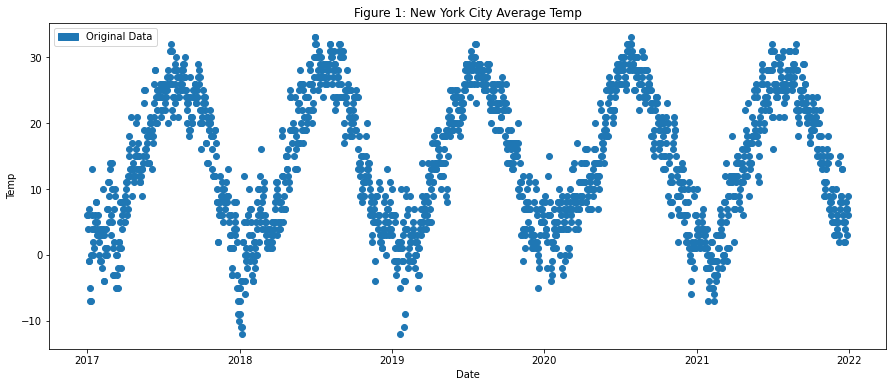

In [7]:
# Defining City
city = 'New York City'

# Plot Figure Parameters
plt.figure(figsize=(15, 6))
plt.title('Figure 1: '+ city + ' Average Temp')
plt.xlabel("Date")
plt.ylabel("Temp")

# Legend
blue_patch = mpatches.Patch(color='C0', label='Original Data')
plt.legend(handles=[blue_patch], loc='upper left')

# Plot
plt.scatter(main.date, main.avgtemp)
plt.show()


# 3. Preliminary EDA

In [8]:
print('New York Avg Temp Statistics')
print('============================')
main.avgtemp.describe()

New York Avg Temp Statistics


count    1826.000000
mean       14.395400
std        10.002041
min       -12.000000
25%         6.000000
50%        14.000000
75%        24.000000
max        33.000000
Name: avgtemp, dtype: float64

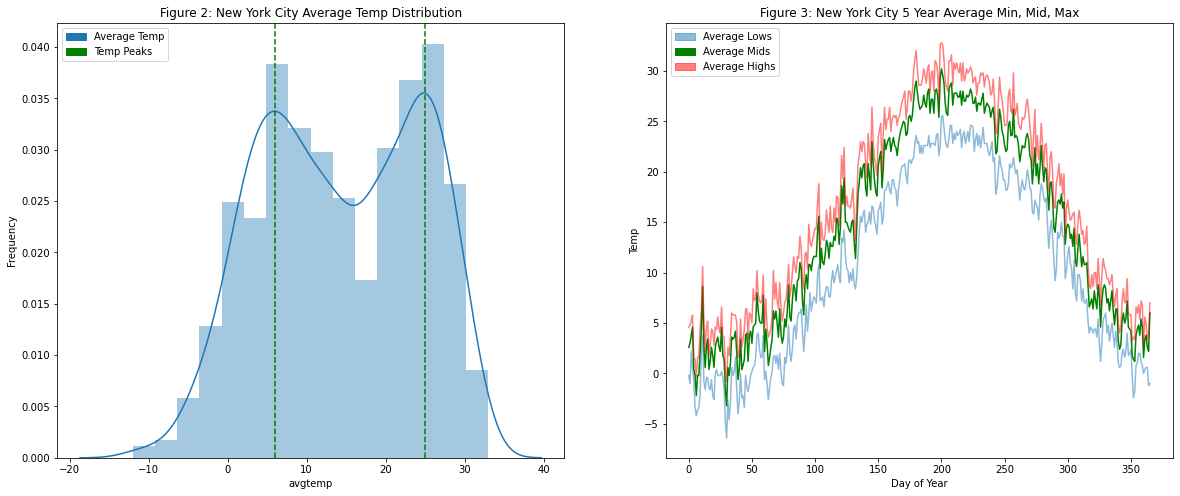

In [13]:
# Figure Size
figure, axis = plt.subplots(1,2, figsize=(20,8))

# Labels
axis[0].set_title('Figure 2: ' + city + ' Average Temp Distribution') 
axis[0].set_xlabel('Date')
axis[0].set_ylabel('Frequency')

axis[1].set_title('Figure 3: ' + city + ' 5 Year Average Min, Mid, Max') 
axis[1].set_xlabel('Day of Year')
axis[1].set_ylabel('Temp')

# Plot 1 - Histogram
blue_patch = mpatches.Patch(color='C0', label='Average Temp')
green_patch = mpatches.Patch(color='green', label='Temp Peaks')
axis[0].legend(handles=[blue_patch, green_patch], loc='upper left')
sns.distplot(main.avgtemp, ax = axis[0])
axis[0].axvline(x=6, linestyle ='--', color = 'green')
axis[0].axvline(x=25, linestyle ='--', color = 'green')

# Plot 2 - Average temps
main['dayofyear'] = [i.dayofyear for i in main.date]
main['month'] = [i.month for i in main.date]
main['day'] = [i.day for i in main.date]

# Removing Leap Day for simplicity
main = main.drop(main[(main.month == 2) & (main.day > 28)].index).reset_index(drop = True)

avg_data = main.groupby(['dayofyear']).mean().reset_index(drop = False)

axis[1].plot(avg_data.mintemp, color = 'C0', alpha = 0.50)
axis[1].plot(avg_data.avgtemp, color = 'green', alpha = 1.00)
axis[1].plot(avg_data.maxtemp, color = 'red', alpha = 0.50)

blue_patch = mpatches.Patch(color='C0', label='Average Lows', alpha = 0.50)
green_patch = mpatches.Patch(color='green', label='Average Mids', alpha = 1.0)
red_patch = mpatches.Patch(color='red', label='Average Highs', alpha = 0.50)
axis[1].legend(handles=[blue_patch, green_patch, red_patch], loc='upper left')

plt.show()



# 4. Outlier Removal Using Hampel

The Hampel filter is generally used to detect anomalies in data with a timeseries structure. It basically consists of a sliding window of a parameterizable size. For each window, each observation will be compared with the Median Absolute Deviation (MAD). The observation will be considered an outlier in the case in which it exceeds the MAD by n times (the parameter n is also parameterizable). For more details, see the following Medium post as well as the Wikipedia entry on MAD.

__Arguments:__
* ts - A pandas Series object representing the timeseries  
* window_size - Total window size will be computed as 2*window_size + 1  
* n - Threshold, default is 3 (Pearson's rule)  
* imputation - If set to False, then the algorithm will be used for outlier detection. If set to True, then the algorithm will also imput the outliers with the rolling median.

__Resource:__  
https://pypi.org/project/hampel/

__Notes__:  
Below we will see a few items  
  1. Outlier Indices is a list of indeces that are considered outliers from Hampel's Test
  2. After correcting the outliers, we have a new but similar graph as the previous one
  3. The red 'X' indicate the position of the outliers
  4. Make sure to 'pip install hampel'

Outlier Indices:  [194, 319, 332, 416, 494, 496, 497, 523, 561, 566, 575, 576, 643, 644, 645, 670, 690, 713, 726, 733, 734, 736, 750, 753, 775, 803, 851, 869, 875, 978, 983, 985, 1002, 1041, 1090, 1092, 1140, 1169, 1173, 1299, 1453, 1454, 1544, 1545, 1547, 1630, 1643, 1655, 1667, 1682, 1683, 1691]


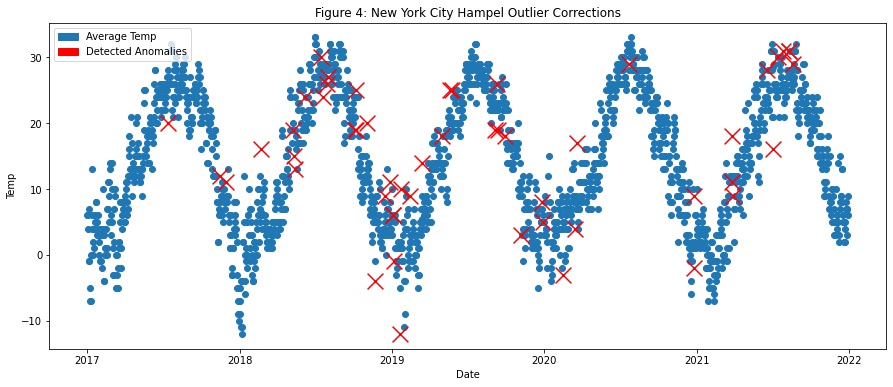

In [15]:
from hampel import hampel

outlier_indices = hampel(main.avgtemp, window_size=5, n=3)

# Just outlier detection
print("Outlier Indices: ", outlier_indices)

# Outlier Imputation with rolling median
corrected_anomalies = hampel(main.avgtemp, window_size=5, n=3, imputation=True)
corrected_anomalies = pd.DataFrame(corrected_anomalies, columns = ['avgtemp']).reset_index(drop = True)
corrected_anomalies['date'] = main.date

# Plot Figure Paramters
plt.figure(figsize=(15, 6))
plt.title('Figure 4: ' + city + ' Hampel Outlier Corrections')
plt.xlabel("Date")
plt.ylabel("Temp")


# Legend
blue_patch = mpatches.Patch(color='C0', label='Average Temp')
red_patch = mpatches.Patch(color='red', label='Detected Anomalies')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

# Corrected Data
plt.scatter(corrected_anomalies.date, corrected_anomalies.avgtemp)

# Color Code Outliers
anomaly_points = main.iloc[outlier_indices]
plt.scatter(anomaly_points.date, anomaly_points.avgtemp, marker = 'x', color = 'red', s = 250)
plt.show()

Outlier Indices:  [194, 319, 332, 416, 494, 496, 497, 523, 561, 566, 575, 576, 643, 644, 645, 670, 690, 713, 726, 733, 734, 736, 750, 753, 775, 803, 851, 869, 875, 978, 983, 985, 1002, 1041, 1090, 1092, 1140, 1169, 1173, 1299, 1453, 1454, 1544, 1545, 1547, 1630, 1643, 1655, 1667, 1682, 1683, 1691]


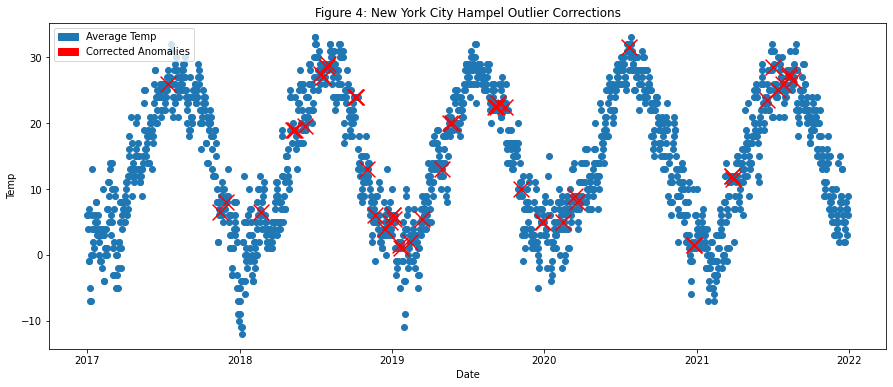

In [16]:
from hampel import hampel

outlier_indices = hampel(main.avgtemp, window_size=5, n=3)

# Just outlier detection
print("Outlier Indices: ", outlier_indices)

# Outlier Imputation with rolling median
corrected_anomalies = hampel(main.avgtemp, window_size=5, n=3, imputation=True)
corrected_anomalies = pd.DataFrame(corrected_anomalies, columns = ['avgtemp']).reset_index(drop = True)
corrected_anomalies['date'] = main.date

# Plot Figure Paramters
plt.figure(figsize=(15, 6))
plt.title('Figure 4: ' + city + ' Hampel Outlier Corrections')
plt.xlabel("Date")
plt.ylabel("Temp")


# Legend
blue_patch = mpatches.Patch(color='C0', label='Average Temp')
red_patch = mpatches.Patch(color='red', label='Corrected Anomalies')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

# Corrected Data
plt.scatter(corrected_anomalies.date, corrected_anomalies.avgtemp)

# Color Code Outliers
anomaly_points = corrected_anomalies.iloc[outlier_indices]
plt.scatter(anomaly_points.date, anomaly_points.avgtemp, marker = 'x', color = 'red', s = 250)
plt.show()

# 5.1 Random Forest Regressor

In [24]:
# Will need to create features
# In this case, we will use the data's own lags as inputs
insert = pd.DataFrame([[1826, None],
              [1827, None],
              [1828, None],
              [1829, None],
              [1830, None]], columns = corrected_anomalies.columns)

feature_engineer = pd.concat([corrected_anomalies,insert]).reset_index(drop = True)
feature_engineer['5_day_lag'] = feature_engineer.avgtemp.shift(5)
feature_engineer['6_day_lag'] = feature_engineer.avgtemp.shift(6)
feature_engineer['7_day_lag'] = feature_engineer.avgtemp.shift(7)
feature_engineer['8_day_lag'] = feature_engineer.avgtemp.shift(8)
feature_engineer['9_day_lag'] = feature_engineer.avgtemp.shift(9)

feature_engineer['365_day_lag'] = feature_engineer.avgtemp.shift(365)
feature_engineer['366_day_lag'] = feature_engineer.avgtemp.shift(366)
feature_engineer['367_day_lag'] = feature_engineer.avgtemp.shift(367)
feature_engineer['368_day_lag'] = feature_engineer.avgtemp.shift(368)
feature_engineer['369_day_lag'] = feature_engineer.avgtemp.shift(369)

# Dropping everything with NA
print('Random Forest Dataset')
five_day = feature_engineer.iloc[-5:].drop(['date', 'avgtemp'], axis=1)
feature_engineer = feature_engineer.iloc[369:-5]
feature_engineer.head()

Random Forest Dataset


,avgtemp,date,5_day_lag,6_day_lag,7_day_lag,8_day_lag,9_day_lag,365_day_lag,366_day_lag,367_day_lag,368_day_lag,369_day_lag
369,-11.0,2018-01-05,-10.0,-5.0,-7.0,-9.0,-5.0,-1.0,7.0,7.0,5.0,6.0
370,-12.0,2018-01-06,-9.0,-10.0,-5.0,-7.0,-9.0,-1.0,-1.0,7.0,7.0,5.0
371,-11.0,2018-01-07,-7.0,-9.0,-10.0,-5.0,-7.0,-5.0,-1.0,-1.0,7.0,7.0
372,-4.0,2018-01-08,-5.0,-7.0,-9.0,-10.0,-5.0,-7.0,-5.0,-1.0,-1.0,7.0
373,2.0,2018-01-09,-4.0,-5.0,-7.0,-9.0,-10.0,-7.0,-7.0,-5.0,-1.0,-1.0


In [25]:
# Splitting the data 80% Train 20% Test
i = 365
X_train, X_test = feature_engineer.drop(['date', 'avgtemp'], axis = 1).iloc[:-i,], feature_engineer.drop(['date', 'avgtemp'], axis = 1).iloc[-i:,]
y_train, y_test = feature_engineer['avgtemp'].iloc[:-i,], feature_engineer['avgtemp'].iloc[-i:,]

# Fitting a model on Training Data
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

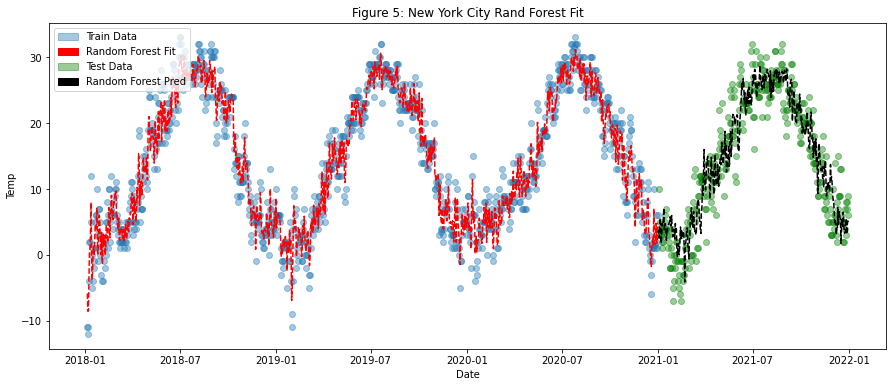

In [26]:
plt.figure(figsize=(15, 6))
plt.title('Figure 5: ' + city + ' Rand Forest Fit')
plt.xlabel("Date")
plt.ylabel("Temp")

# Plotting Train Values 
plt.scatter(feature_engineer['date'].iloc[:-i,], y_train, color = 'C0', alpha = .4)

# Plotting Test Values
plt.scatter(feature_engineer['date'].iloc[-i:,], y_test, color = 'green', alpha = .4)

# Plotting Cosine Function Train
plt.plot(feature_engineer['date'].iloc[:-i,], rf_model.predict(X_train), color = 'red',linestyle = '--')

# Plotting Cosine Function Test
plt.plot(feature_engineer['date'].iloc[-i:,], rf_model.predict(X_test), color = 'black',linestyle = '--')


# Creating Legend
blue_patch = mpatches.Patch(color='C0', label='Train Data', alpha = .4)
red_patch = mpatches.Patch(color='red', label='Random Forest Fit')
green_patch = mpatches.Patch(color='green', label='Test Data', alpha = .4)
black_patch = mpatches.Patch(color='black', label='Random Forest Pred')
plt.legend(handles=[blue_patch, red_patch, green_patch, black_patch], loc='upper left')

plt.show();

# 5.2 Random Forest Validation & 5 Day Forecast

In [27]:
# Pred and Actual
predictions = rf_model.predict(X_test)
actuals = y_test

# Root Mean Squared Error
print('RMSE: ', mean_squared_error(actuals, predictions, squared=False))
print()

# 5 Day Prediction
print('Next 5 Day Weather Prediction:')
print('=============================:')
print('01-01-2022', rf_model.predict(five_day)[0])
print('01-02-2022', rf_model.predict(five_day)[1])
print('01-03-2022', rf_model.predict(five_day)[2])
print('01-04-2022', rf_model.predict(five_day)[3])
print('01-05-2022', rf_model.predict(five_day)[4])

RMSE:  4.109723835004002

Next 5 Day Weather Prediction:
=============================:
01-01-2022 5.105
01-02-2022 6.73
01-03-2022 6.79
01-04-2022 6.205
01-05-2022 7.23


# 6.1 Cosine Fit

Amplitude=-13.039079353497584, Angular freq.=0.017263762560053058, phase=1.0931979918607122, offset=14.374448568153039, Max. Cov.=0.019184154022072086


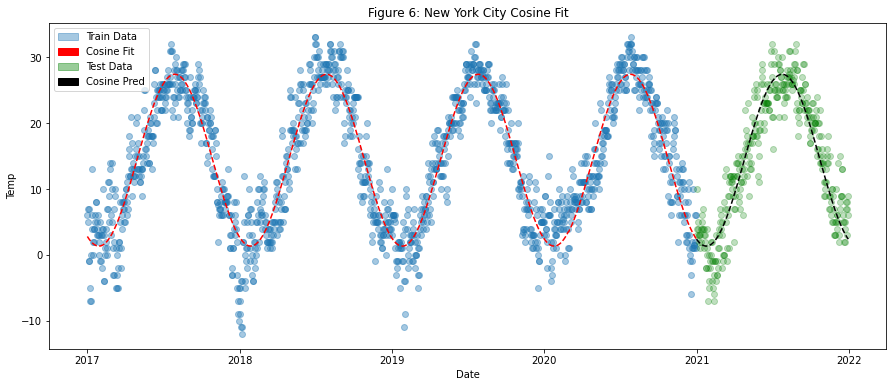

In [28]:
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}
# Resource: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy


# Train/Test Split  (First 4 years of Train Last 1 year test (20%))
i = 365
X_train, X_test = corrected_anomalies['date'].iloc[:-i,], corrected_anomalies['date'].iloc[-i:,]
y_train, y_test = corrected_anomalies['avgtemp'].iloc[:-i,], corrected_anomalies['avgtemp'].iloc[-i:,]

res = fit_sin(y_train.index, y_train)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

plt.figure(figsize=(15, 6))
plt.title('Figure 6: ' + city + ' Cosine Fit')

plt.xlabel("Date")
plt.ylabel("Temp")

# Plotting Train Values 
plt.scatter(X_train,y_train, color = 'C0', alpha = .4)

# Plotting Test Values
plt.scatter(X_test,y_test, color = 'green', alpha = .25)

# Plotting Cosine Function Train
plt.plot(X_train, res["fitfunc"](y_train.index), color = 'red',linestyle = '--')

# Plotting Cosine Function Test
plt.plot(X_test, res["fitfunc"](y_test.index), color = 'black',linestyle = '--')


# Creating Legend
blue_patch = mpatches.Patch(color='C0', label='Train Data', alpha = .4)
red_patch = mpatches.Patch(color='red', label='Cosine Fit')
green_patch = mpatches.Patch(color='green', label='Test Data', alpha = .4)
black_patch = mpatches.Patch(color='black', label='Cosine Pred')
plt.legend(handles=[blue_patch, red_patch, green_patch, black_patch], loc='upper left')

plt.show();

# 6.2 Cosine Validation & 5 Day Forecast

In [29]:
# Pred and Actual
predictions = res["fitfunc"](y_test.index)
actuals = y_test

# Root Mean Squared Error
print('RMSE: ', mean_squared_error(actuals, predictions, squared=False))
print()

# 5 Day Prediction
print('Next 5 Day Weather Prediction:')
print('=============================:')
print('01-01-2022', res["fitfunc"](range(1826, 1831))[0])
print('01-02-2022', res["fitfunc"](range(1826, 1831))[1])
print('01-03-2022', res["fitfunc"](range(1826, 1831))[2])
print('01-04-2022', res["fitfunc"](range(1826, 1831))[3])
print('01-05-2022', res["fitfunc"](range(1826, 1831))[4])

RMSE:  3.5664204372827832

Next 5 Day Weather Prediction:
=============================:
01-01-2022 2.2172606456952852
01-02-2022 2.1376975223631494
01-03-2022 2.0617813191151164
01-04-2022 1.9895346612645302
01-05-2022 1.9209790804896745


# 7.1 ARIMA Forecast

In [30]:
# Train/Test Split  (First 4 years of Train Last 1 year test (20%))
ARIMA_data = corrected_anomalies.copy()
ARIMA_data.index = ARIMA_data.date
ARIMA_data = ARIMA_data.drop(['date'], axis = 1)

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(ARIMA_data.avgtemp, start_p=0, start_q=0,start_d=0, max_p=10, max_q=10, max_d = 10,
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise = False)

print(model.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15618.103, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13540.086, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=12253.746, Time=0.59 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=11551.773, Time=0.80 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=11073.045, Time=0.94 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=10761.656, Time=1.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9403.154, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9337.558, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9188.169, Time=0.59 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=9163.401, Time=0.51 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=9165.092, Time=0.56 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9371.678, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9180.228, Time=1.39 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9162.452, Time=1.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=9164.380, Time=1.59 sec
 ARI

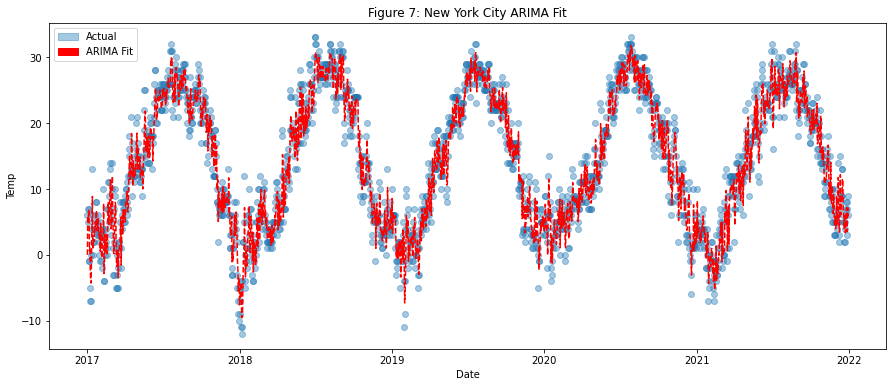

In [31]:
plt.figure(figsize=(15, 6))
plt.title('Figure 7: ' + city + ' ARIMA Fit')

plt.xlabel("Date")
plt.ylabel("Temp")

# Plotting Train Values 
plt.scatter(ARIMA_data.index,ARIMA_data.avgtemp, color = 'C0', alpha = .4)

# Plotting Test Values
#plt.scatter(y_test.index,y_test, color = 'green', alpha = .25)

# Plotting ARIMA Function Train
plt.plot(ARIMA_data.index, model.predict_in_sample(), color = 'red',linestyle = '--')

# Creating Legend
blue_patch = mpatches.Patch(color='C0', label='Actual', alpha = .4)
red_patch = mpatches.Patch(color='red', label='ARIMA Fit')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

plt.show();




# 7.2 ARIMA Validation & 5 Day Forecast

In [32]:
# Pred and Actual
predictions = model.predict_in_sample()[-365:]
actuals = ARIMA_data.avgtemp[-365:]

# Root Mean Squared Error
print('RMSE: ', mean_squared_error(actuals, predictions, squared=False))
print()

# 5 Day Prediction
print('Next 5 Day Weather Prediction:')
print('=============================:')
print('01-01-2022', model.predict(5)[0])
print('01-02-2022', model.predict(5)[1])
print('01-03-2022', model.predict(5)[2])
print('01-04-2022', model.predict(5)[3])
print('01-05-2022', model.predict(5)[4])

RMSE:  3.074214721077092

Next 5 Day Weather Prediction:
=============================:
01-01-2022 8.276382091851888
01-02-2022 7.44564874686484
01-03-2022 7.148796826263085
01-04-2022 7.037061778374758
01-05-2022 6.9895248503106355
